In [72]:
import os
import sys
os.environ["JAVA_HOME"] = "../data-engineering/.JDK 8"
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

In [73]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count
import requests, json

# Create SparkSession
spark = SparkSession \
    .builder \
        .appName("GreenDataAnalyticsProject") \
            .getOrCreate()

25/03/27 21:03:07 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [74]:
api_url = "https://maps2.bristol.gov.uk/server2/rest/services/ext/air_quality/MapServer/0/query?outFields=*&where=1%3D1&f=geojson"

try:
    response = requests.get(api_url)
    geojson_data = response.json()
except requests.exceptions.HTTPError as http_err:
    # This block handles HTTP errors (e.g., 404, 500)
    print(f"HTTP error occurred: {http_err}")

except requests.exceptions.ConnectionError as conn_err:
    # This block handles issues like network errors, no connection
    print(f"Connection error occurred: {conn_err}")

except requests.exceptions.Timeout as timeout_err:
    # This block handles timeouts
    print(f"Timeout error occurred: {timeout_err}")

except requests.exceptions.RequestException as req_err:
    # This block handles any other request-related errors
    print(f"An error occurred with the request: {req_err}")

except ValueError as json_err:
    # This block handles errors related to JSON parsing
    print(f"Failed to parse JSON: {json_err}")

except Exception as e:
    # This block handles any unexpected errors
    print(f"An unexpected error occurred: {e}")

In [75]:
features = geojson_data.get("features", [])
json_features = [json.dumps(feature) for feature in features]
rdd = spark.sparkContext.parallelize(json_features)
df = spark.read.json(rdd)


In [76]:
df.show()

+--------------------+---+--------------------+-------+
|            geometry| id|          properties|   type|
+--------------------+---+--------------------+-------+
|{[-2.627748803206...|  1|{Yes, NULL, No, N...|Feature|
|{[-2.596813947482...|  2|{Yes, NULL, Yes, ...|Feature|
|{[-2.613994167991...|  3|{No, NULL, Yes, N...|Feature|
|{[-2.578333463205...|  4|{Yes, NULL, Yes, ...|Feature|
|{[-2.595294420664...|  5|{Yes, NULL, Yes, ...|Feature|
|{[-2.558965289247...|  6|{Yes, NULL, No, N...|Feature|
|{[-2.697147645214...|  7|{No, NULL, No, NU...|Feature|
|{[-2.579303486860...|  8|{Yes, NULL, No, N...|Feature|
|{[-2.595417508199...|  9|{Yes, NULL, Yes, ...|Feature|
|{[-2.559380932414...| 10|{Yes, NULL, Yes, ...|Feature|
|{[-2.594190185154...| 11|{Yes, NULL, Yes, ...|Feature|
|{[-2.589439954461...| 12|{Yes, NULL, Yes, ...|Feature|
|{[-2.656900421884...| 13|{No, NULL, No, NU...|Feature|
|{[-2.564144569808...| 14|{Yes, NULL, Yes, ...|Feature|
|{[-2.587283945975...| 15|{Yes, NULL, Yes, ...|F

In [77]:
df = df.select('id',
               col('properties.SiteID').alias('SiteID'),
    col('properties.location').alias('location'),
    col('properties.LocationClass').alias('Location Type'),
    df.geometry.coordinates.alias("coordinates"),
    col('properties.Pollutants').alias('Pollutants'),
    col('properties.Elevation').alias('Elevation')
    )





In [78]:
df.show(1, truncate=False)

+---+------+----------------+-------------+-----------------------------------------+----------+---------+
|id |SiteID|location        |Location Type|coordinates                              |Pollutants|Elevation|
+---+------+----------------+-------------+-----------------------------------------+----------+---------+
|1  |1     |Withywood School|Urban Traffic|[-2.6277488032062446, 51.407745517999835]|BTX NO2   |NULL     |
+---+------+----------------+-------------+-----------------------------------------+----------+---------+
only showing top 1 row



In [79]:
df = df.withColumn("Longitude", col("coordinates")[0])

In [80]:
df = df.withColumn("Latitude", col("coordinates")[1])

In [81]:
from pyspark.sql import functions as F
max_value = df.agg(F.max('Latitude')).collect()[0][0]
min_value = df.agg(F.min('Latitude')).collect()[0][0]

def normalise(original_value):
    scaled_value = (original_value - min_value) / (max_value - min_value)
    return scaled_value
    

In [82]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
normalise_udf = udf(normalise, DoubleType())


In [83]:
df = df.withColumn("Latitude (Normalised)", normalise_udf("Latitude")) # .drop("Latitude")
df.show(truncate=False)

+---+------+-----------------+----------------+-----------------------------------------+----------+---------+-------------------+------------------+---------------------+
|id |SiteID|location         |Location Type   |coordinates                              |Pollutants|Elevation|Longitude          |Latitude          |Latitude (Normalised)|
+---+------+-----------------+----------------+-----------------------------------------+----------+---------+-------------------+------------------+---------------------+
|1  |1     |Withywood School |Urban Traffic   |[-2.6277488032062446, 51.407745517999835]|BTX NO2   |NULL     |-2.6277488032062446|51.407745517999835|0.0909330382676792   |
|2  |2     |Colston Avenue   |Urban Traffic   |[-2.5968139474821794, 51.454556566902696]|NO2       |9.5      |-2.5968139474821794|51.454556566902696|0.2938159127984107   |
|3  |3     |Blackboy Hill    |Urban Traffic   |[-2.613994167991525, 51.46920548941127]  |NO2       |79.2     |-2.613994167991525 |51.4692054

In [84]:
df.toPandas().to_csv("cleanedAirQualityData.csv", index=False)

In [85]:
# Create SparkSession
spark = SparkSession \
    .builder \
        .appName("GreenDataAnalyticsProjectII") \
            .getOrCreate()

25/03/27 21:03:09 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [86]:
url = "jdbc:postgresql://localhost:5432/etlassignment"
properties = {
    "user": "postgres",
    "password": "Cheesecake",
    "driver": "org.postgresql.Driver"
}

df.write.jdbc(url=url, table="airqualitybristol", properties=properties, mode="overwrite")

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

In [88]:
df.drop("id")\
    .toPandas()

,SiteID,location,Location Type,coordinates,Pollutants,Elevation,Longitude,Latitude,Latitude (Normalised)
0,1,Withywood School,Urban Traffic,"[-2.6277488032062446, 51.407745517999835]",BTX NO2,NaN,-2.627749,51.407746,0.090933
1,2,Colston Avenue,Urban Traffic,"[-2.5968139474821794, 51.454556566902696]",NO2,9.5,-2.596814,51.454557,0.293816
2,3,Blackboy Hill,Urban Traffic,"[-2.613994167991525, 51.46920548941127]",NO2,79.2,-2.613994,51.469205,0.357306
3,4,Three Lamps,Urban Traffic,"[-2.578333463205696, 51.444209895530584]",NO2,26.6,-2.578333,51.444210,0.248973
4,5,Bedminster Parade,Urban Traffic,"[-2.595294420664777, 51.442812042759506]",NO2,8.1,-2.595294,51.442812,0.242914
...,...,...,...,...,...,...,...,...,...
695,707,Rodney Road junction with Whiteway Road,None,"[-2.5279124420175134, 51.46529043268529]",NO2,NaN,-2.527912,51.465290,0.340337
696,708,Whiteway Road junction with A420,None,"[-2.5356705609472345, 51.4615416882718]",NO2,NaN,-2.535671,51.461542,0.324090
697,709,Air Balloon Hill Primary School,None,"[-2.530569245243335, 51.458570621919755]",NO2,NaN,-2.530569,51.458571,0.311213
698,710,Nags Head Hill,None,"[-2.5259994213446975, 51.45419426540695]",NO2,NaN,-2.525999,51.454194,0.292246


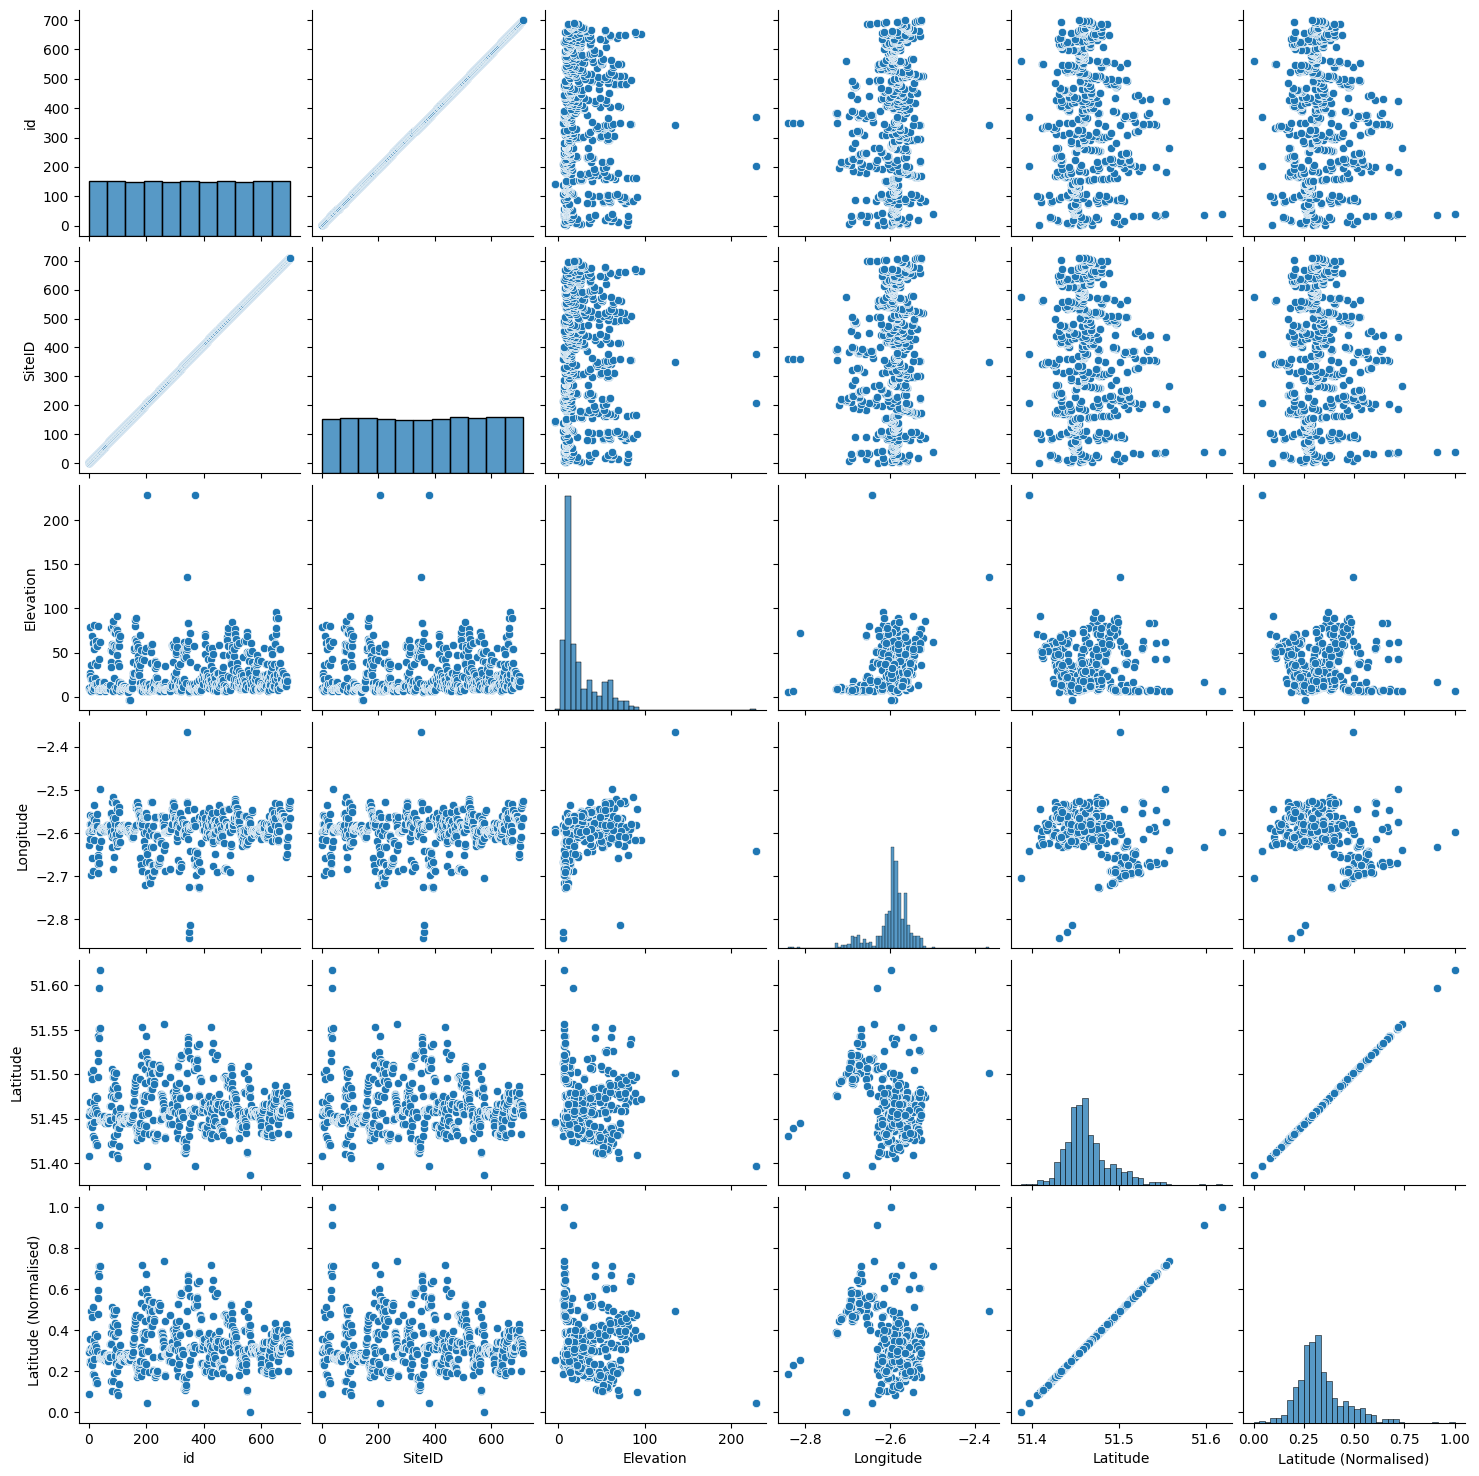

In [89]:
sns.pairplot(data=df.toPandas())

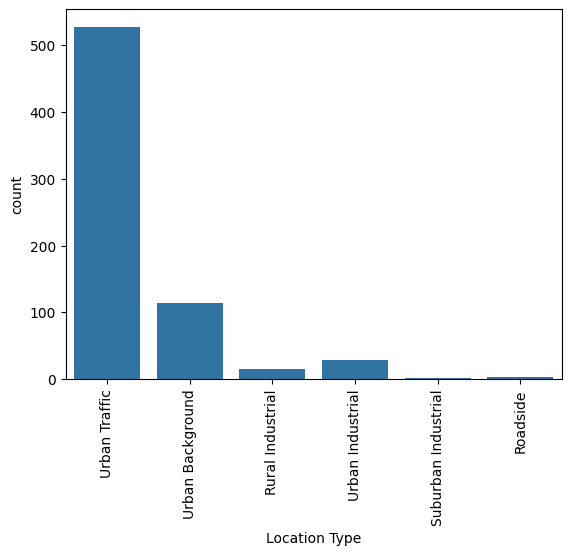

In [90]:
# df.groupBy("Location Type").count("Location Type")\
#     .show()

loctype_df = df.groupBy("Location Type").count()
sns.barplot(data=loctype_df.toPandas(), x="Location Type", y="count")
plt.xticks(rotation=90)
plt.show()

In [91]:
df.toPandas()

,id,SiteID,location,Location Type,coordinates,Pollutants,Elevation,Longitude,Latitude,Latitude (Normalised)
0,1,1,Withywood School,Urban Traffic,"[-2.6277488032062446, 51.407745517999835]",BTX NO2,NaN,-2.627749,51.407746,0.090933
1,2,2,Colston Avenue,Urban Traffic,"[-2.5968139474821794, 51.454556566902696]",NO2,9.5,-2.596814,51.454557,0.293816
2,3,3,Blackboy Hill,Urban Traffic,"[-2.613994167991525, 51.46920548941127]",NO2,79.2,-2.613994,51.469205,0.357306
3,4,4,Three Lamps,Urban Traffic,"[-2.578333463205696, 51.444209895530584]",NO2,26.6,-2.578333,51.444210,0.248973
4,5,5,Bedminster Parade,Urban Traffic,"[-2.595294420664777, 51.442812042759506]",NO2,8.1,-2.595294,51.442812,0.242914
...,...,...,...,...,...,...,...,...,...,...
695,696,707,Rodney Road junction with Whiteway Road,None,"[-2.5279124420175134, 51.46529043268529]",NO2,NaN,-2.527912,51.465290,0.340337
696,697,708,Whiteway Road junction with A420,None,"[-2.5356705609472345, 51.4615416882718]",NO2,NaN,-2.535671,51.461542,0.324090
697,698,709,Air Balloon Hill Primary School,None,"[-2.530569245243335, 51.458570621919755]",NO2,NaN,-2.530569,51.458571,0.311213
698,699,710,Nags Head Hill,None,"[-2.5259994213446975, 51.45419426540695]",NO2,NaN,-2.525999,51.454194,0.292246


In [92]:
import plotly.express as px
import geopandas as gpd

geo_df = df.toPandas()

fig = px.scatter_map(geo_df,
                        lat="Latitude",
                        lon="Longitude",
                        hover_name="location",
                        zoom=10)
fig.show()

In [93]:
csv_df = spark.read.csv("ContinuousAirQuality.csv", header=True, inferSchema=True)

In [103]:
null_count = csv_df.select([F.sum(col(c).isNull().cast("int")).alias(c) for c in csv_df.columns])
null_count.show()


+-------+--------+-------+--------+---------+---+---+---+-----+----+
|SITE_ID|LOCATION|EASTING|NORTHING|DATE_TIME| NO|NOX|NO2|PM2_5|PM10|
+-------+--------+-------+--------+---------+---+---+---+-----+----+
|      0|       0|      0|       0|        0|  0|  0|  0|    0|   0|
+-------+--------+-------+--------+---------+---+---+---+-----+----+



In [125]:
csv_df.filter(col("NO").isNull()).show()

+-------+-------------------+-------+--------+----------------+----+----+----+-----+----+
|SITE_ID|           LOCATION|EASTING|NORTHING|       DATE_TIME|  NO| NOX| NO2|PM2_5|PM10|
+-------+-------------------+-------+--------+----------------+----+----+----+-----+----+
|    188|AURN Bristol Centre| 359406|  173299|01/01/1993 00:00|NULL|NULL|NULL| NULL|NULL|
|    188|AURN Bristol Centre| 359406|  173299|01/01/1993 01:00|NULL|NULL|NULL| NULL|NULL|
|    188|AURN Bristol Centre| 359406|  173299|01/01/1993 02:00|NULL|NULL|NULL| NULL|NULL|
|    188|AURN Bristol Centre| 359406|  173299|01/01/1993 03:00|NULL|NULL|NULL| NULL|NULL|
|    188|AURN Bristol Centre| 359406|  173299|01/01/1993 04:00|NULL|NULL|NULL| NULL|NULL|
|    188|AURN Bristol Centre| 359406|  173299|01/01/1993 05:00|NULL|NULL|NULL| NULL|NULL|
|    188|AURN Bristol Centre| 359406|  173299|01/01/1993 06:00|NULL|NULL|NULL| NULL|NULL|
|    188|AURN Bristol Centre| 359406|  173299|01/01/1993 07:00|NULL|NULL|NULL| NULL|NULL|
|    188|A

In [102]:
csv_df_clean = csv_df.dropna(how="any")

+-------+------------------+
|SITE_ID|            Avg_NO|
+-------+------------------+
|    203| 22.48464297281046|
|    188| 39.14171432878855|
|    206| 169.8539232950572|
|    209|  88.6956860564742|
|    213| 65.63642083501865|
|    215| 38.35466068825329|
|    228|102.17944026030236|
|    270| 42.96461048147476|
|    271|16.388610912902664|
|    375|58.118193114895924|
|    395|36.446677771684314|
|    452|12.145855352520629|
|    447|46.801717481939264|
|    463|28.451024349974848|
|    459|28.735420389347617|
|    481|              NULL|
|    501| 65.15577366452885|
|    500|24.086869128595477|
|    672|19.529733017499506|
+-------+------------------+



<Axes: xlabel='SITE_ID', ylabel='Avg_NO'>

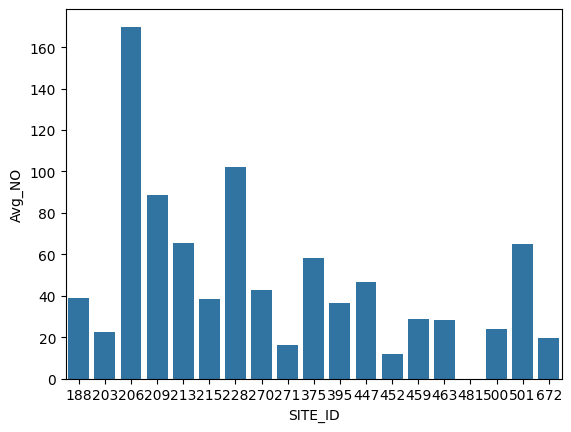

In [127]:
data = csv_df.groupBy("SITE_ID").agg(F.avg("NO").alias("Avg_NO"))
data.show()
sns.barplot(data=data.toPandas(), x="SITE_ID", y="Avg_NO")

In [59]:
csv_df.show()

+-------+-------------------+-------+--------+----------------+----+----+----+-----+----+
|SITE_ID|           LOCATION|EASTING|NORTHING|       DATE_TIME|  NO| NOX| NO2|PM2_5|PM10|
+-------+-------------------+-------+--------+----------------+----+----+----+-----+----+
|    188|AURN Bristol Centre| 359406|  173299|01/01/1993 00:00|NULL|NULL|NULL| NULL|NULL|
|    188|AURN Bristol Centre| 359406|  173299|01/01/1993 01:00|NULL|NULL|NULL| NULL|NULL|
|    188|AURN Bristol Centre| 359406|  173299|01/01/1993 02:00|NULL|NULL|NULL| NULL|NULL|
|    188|AURN Bristol Centre| 359406|  173299|01/01/1993 03:00|NULL|NULL|NULL| NULL|NULL|
|    188|AURN Bristol Centre| 359406|  173299|01/01/1993 04:00|NULL|NULL|NULL| NULL|NULL|
|    188|AURN Bristol Centre| 359406|  173299|01/01/1993 05:00|NULL|NULL|NULL| NULL|NULL|
|    188|AURN Bristol Centre| 359406|  173299|01/01/1993 06:00|NULL|NULL|NULL| NULL|NULL|
|    188|AURN Bristol Centre| 359406|  173299|01/01/1993 07:00|NULL|NULL|NULL| NULL|NULL|
|    188|A

In [58]:
csv_df.select("LOCATION").distinct().show(truncate=False)

+--------------------------------+
|LOCATION                        |
+--------------------------------+
|Brislington Depot               |
|AURN Bristol Centre             |
|Rupert Street                   |
|IKEA M32                        |
|Old Market                      |
|Parson Street School            |
|Temple Meads Station            |
|Wells Road                      |
|Trailer Portway P&R             |
|Newfoundland Road Police Station|
|Shiner's Garage                 |
|AURN St Pauls                   |
|Bath Road                       |
|Fishponds Road                  |
|Cheltenham Road \ Station Road  |
|CREATE Centre Roof              |
|Temple Way                      |
|Colston Avenue                  |
|Marlborough Street              |
+--------------------------------+



In [62]:
csv_df.filter(col("LOCATION").contains("AURN Bristol Centre")).count()


113910